In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from preprocessing import *
import sys
sys.path.append("../..")
from Utils.utils import *

In [2]:
df = pd.read_csv("community_ts.csv", header=0, index_col="date", parse_dates=["date"])
# Create a complete date range from the start to the end of the existing index
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame with the complete date range
df = df.reindex(complete_date_range)

# Fill missing values (forward fill)
df.fillna(method='ffill', inplace=True)
df

/tmp/ipykernel_269216/2998218164.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


checkins
2010-01-16       6.0
2010-01-17       8.0
2010-01-18       8.0
2010-01-19       4.0
2010-01-20       1.0
...              ...
2022-01-15      19.0
2022-01-16      19.0
2022-01-17      13.0
2022-01-18       5.0
2022-01-19       4.0

[4387 rows x 1 columns]

In [3]:
main_metrics = df.describe().T
main_metrics

count       mean        std  min   25%   50%   75%    max
checkins  4387.0  59.198997  41.722809  1.0  25.0  54.0  82.5  202.0

### Plot Time Series

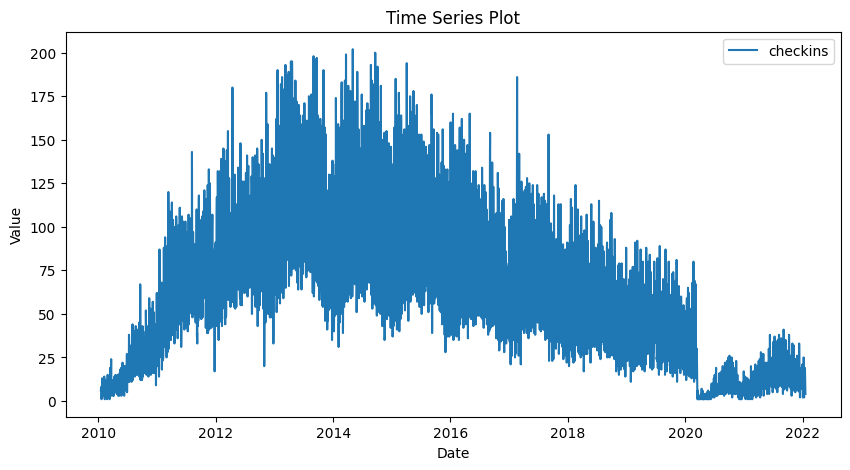

In [4]:
plot_timeseries(df)

### Checkins Distribution

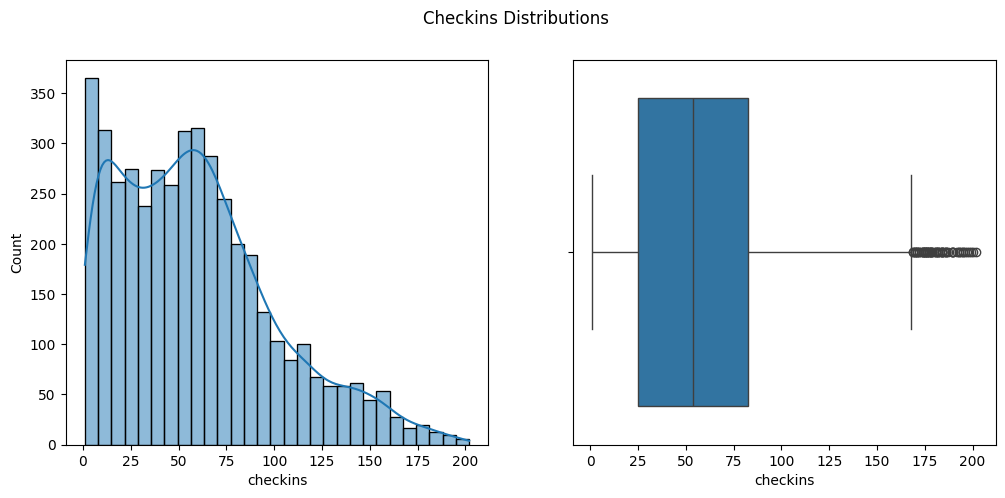

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5 ))
sns.histplot(data=df, x="checkins", ax=ax1, kde=True)
fig.suptitle("Checkins Distributions")
sns.boxplot(data=df, x="checkins", ax=ax2)
plt.show()

In [46]:
dummy_feat_df = extract_dummy_features(df)
dummy_feat_df

checkins  day  month  year  weekday  is_weekend  week_of_year  \
2010-01-16       6.0   16      1  2010        5           1             2   
2010-01-17       8.0   17      1  2010        6           1             2   
2010-01-18       8.0   18      1  2010        0           0             3   
2010-01-19       4.0   19      1  2010        1           0             3   
2010-01-20       1.0   20      1  2010        2           0             3   
...              ...  ...    ...   ...      ...         ...           ...   
2022-01-15      19.0   15      1  2022        5           1             2   
2022-01-16      19.0   16      1  2022        6           1             2   
2022-01-17      13.0   17      1  2022        0           0             3   
2022-01-18       5.0   18      1  2022        1           0             3   
2022-01-19       4.0   19      1  2022        2           0             3   

            quarter  is_month_start  is_month_end  
2010-01-16        1               0             0  
2010-01-17        1               0             0  
2010-01-18        1               0             0  
2010-01-19        1               0             0  
2010-01-20        1               0             0  
...             ...             ...           ...  
2022-01-15        1               0             0  
2022-01-16        1               0             0  
2022-01-17        1               0             0  
2022-01-18        1               0             0  
2022-01-19        1               0             0  

[4387 rows x 10 columns]

In [47]:
# fourier_df = apply_fourier_transformation(dummy_feat_df, target_col="checkins")
# fourier_df

In [48]:
lagged_df = create_robust_lag_features(dummy_feat_df, column="checkins", n_lags=3)
lagged_df

checkins  day  month  year  weekday  is_weekend  week_of_year  \
2011-01-16      87.0   16      1  2011        6           1             2   
2011-01-17      45.0   17      1  2011        0           0             3   
2011-01-18      26.0   18      1  2011        1           0             3   
2011-01-19      35.0   19      1  2011        2           0             3   
2011-01-20      34.0   20      1  2011        3           0             3   
...              ...  ...    ...   ...      ...         ...           ...   
2022-01-15      19.0   15      1  2022        5           1             2   
2022-01-16      19.0   16      1  2022        6           1             2   
2022-01-17      13.0   17      1  2022        0           0             3   
2022-01-18       5.0   18      1  2022        1           0             3   
2022-01-19       4.0   19      1  2022        2           0             3   

            quarter  is_month_start  is_month_end  lag_1_day  lag_2_day  \
2011-01-16        1               0             0       58.0       31.0   
2011-01-17        1               0             0       87.0       58.0   
2011-01-18        1               0             0       45.0       87.0   
2011-01-19        1               0             0       26.0       45.0   
2011-01-20        1               0             0       35.0       26.0   
...             ...             ...           ...        ...        ...   
2022-01-15        1               0             0       12.0        4.0   
2022-01-16        1               0             0       19.0       12.0   
2022-01-17        1               0             0       19.0       19.0   
2022-01-18        1               0             0       13.0       19.0   
2022-01-19        1               0             0        5.0       13.0   

            lag_3_day  lag_1_week lag_1_month lag_1_year  
2011-01-16       14.0        62.0        23.0        6.0  
2011-01-17       31.0        32.0        36.0        8.0  
2011-01-18       58.0        23.0        39.0        8.0  
2011-01-19       87.0        22.0        44.0        4.0  
2011-01-20       45.0        14.0        24.0        1.0  
...               ...         ...         ...        ...  
2022-01-15       13.0        25.0        12.0        5.0  
2022-01-16        4.0        22.0         2.0        7.0  
2022-01-17       12.0         3.0        10.0       13.0  
2022-01-18       19.0         2.0        19.0        5.0  
2022-01-19       19.0        13.0        16.0        6.0  

[4022 rows x 16 columns]

In [61]:
lagged_df = add_holiday_column(lagged_df, us_state="PA")
lagged_df = add_crisis_and_covid_columns(lagged_df, additional_crisis_periods=None)
lagged_rolling_df = create_rolling_features(lagged_df, target_col="checkins", windows=[7, 30])
lagged_rolling_df

checkins  day  month  year  weekday  is_weekend  week_of_year  \
2011-02-15      40.0   15      2  2011        1           0             7   
2011-02-16      38.0   16      2  2011        2           0             7   
2011-02-17      34.0   17      2  2011        3           0             7   
2011-02-18      49.0   18      2  2011        4           0             7   
2011-02-19      73.0   19      2  2011        5           1             7   
...              ...  ...    ...   ...      ...         ...           ...   
2022-01-15      19.0   15      1  2022        5           1             2   
2022-01-16      19.0   16      1  2022        6           1             2   
2022-01-17      13.0   17      1  2022        0           0             3   
2022-01-18       5.0   18      1  2022        1           0             3   
2022-01-19       4.0   19      1  2022        2           0             3   

            quarter  is_month_start  is_month_end  ...  \
2011-02-15        1               0             0  ...   
2011-02-16        1               0             0  ...   
2011-02-17        1               0             0  ...   
2011-02-18        1               0             0  ...   
2011-02-19        1               0             0  ...   
...             ...             ...           ...  ...   
2022-01-15        1               0             0  ...   
2022-01-16        1               0             0  ...   
2022-01-17        1               0             0  ...   
2022-01-18        1               0             0  ...   
2022-01-19        1               0             0  ...   

            checkins_7window_pct_change_lag  checkins_30window_mean  \
2011-02-15                         0.538462               41.266667   
2011-02-16                         0.117647               41.033333   
2011-02-17                        -0.081081               41.300000   
2011-02-18                         0.088889               41.766667   
2011-02-19                        -0.170455               43.066667   
...                                     ...                     ...   
2022-01-15                        -0.240000               11.600000   
2022-01-16                        -0.136364               11.900000   
2022-01-17                         3.333333               11.700000   
2022-01-18                         1.500000               11.333333   
2022-01-19                        -0.692308               11.166667   

            checkins_30window_var  checkins_30window_slope  \
2011-02-15             275.788506                -1.566667   
2011-02-16             275.619540                -0.233333   
2011-02-17             269.458621                 0.266667   
2011-02-18             269.909195                 0.466667   
2011-02-19             299.719540                 1.300000   
...                           ...                      ...   
2022-01-15              39.006897                 0.566667   
2022-01-16              40.713793                 0.300000   
2022-01-17              38.975862                -0.200000   
2022-01-18              39.747126                -0.366667   
2022-01-19              41.385057                -0.166667   

           checkins_30window_ema checkins_30window_rolling_max  \
2011-02-15             49.129526                          88.0   
2011-02-16             48.411492                          88.0   
2011-02-17             47.481719                          88.0   
2011-02-18             47.579672                          88.0   
2011-02-19             49.219693                          88.0   
...                          ...                           ...   
2022-01-15             11.558186                          25.0   
2022-01-16             12.038303                          25.0   
2022-01-17             12.100348                          25.0   
2022-01-18             11.642261                          25.0   
2022-01-19             11.149212                          25.0   


In [62]:
final_df = fetch_and_merge_economic_data(lagged_rolling_df).dropna()
final_df

<class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


/home/igdiniz/FEUP/MECD/year2/ADC/project/ADC-MECD/notebooks/second_part/preprocessing.py:509: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = df.merge(unemployment_rate, left_index=True, right_index=True, how='left').ffill()


checkins  day  month  year  weekday  is_weekend  week_of_year  \
2011-04-01      76.0    1      4  2011        4           0            13   
2011-04-02      97.0    2      4  2011        5           1            13   
2011-04-03     114.0    3      4  2011        6           1            13   
2011-04-04      38.0    4      4  2011        0           0            14   
2011-04-05      46.0    5      4  2011        1           0            14   
...              ...  ...    ...   ...      ...         ...           ...   
2022-01-15      19.0   15      1  2022        5           1             2   
2022-01-16      19.0   16      1  2022        6           1             2   
2022-01-17      13.0   17      1  2022        0           0             3   
2022-01-18       5.0   18      1  2022        1           0             3   
2022-01-19       4.0   19      1  2022        2           0             3   

            quarter  is_month_start  is_month_end  ...  checkins_30window_ema  \
2011-04-01        2               1             0  ...              60.780992   
2011-04-02        2               0             0  ...              63.117702   
2011-04-03        2               0             0  ...              66.400431   
2011-04-04        2               0             0  ...              64.568145   
2011-04-05        2               0             0  ...              63.370201   
...             ...             ...           ...  ...                    ...   
2022-01-15        1               0             0  ...              11.558186   
2022-01-16        1               0             0  ...              12.038303   
2022-01-17        1               0             0  ...              12.100348   
2022-01-18        1               0             0  ...              11.642261   
2022-01-19        1               0             0  ...              11.149212   

            checkins_30window_rolling_max  checkins_30window_rolling_min  \
2011-04-01                          120.0                           28.0   
2011-04-02                          120.0                           28.0   
2011-04-03                          120.0                           28.0   
2011-04-04                          120.0                           28.0   
2011-04-05                          120.0                           28.0   
...                                   ...                            ...   
2022-01-15                           25.0                            2.0   
2022-01-16                           25.0                            2.0   
2022-01-17                           25.0                            2.0   
2022-01-18                           25.0                            2.0   
2022-01-19                           25.0                            2.0   

            checkins_30window_skew  checkins_30window_kurt  \
2011-04-01                0.626538               -0.890964   
2011-04-02                0.487372               -1.101781   
2011-04-03                0.374457               -1.272709   
2011-04-04                0.506288               -1.173603   
2011-04-05                0.567445               -1.160992   
...                            ...                     ...   
2022-01-15                0.330811               -0.655560   
2022-01-16                0.217200               -0.862359   
2022-01-17                0.280755               -0.673911   
2022-01-18                0.403715               -0.648491   
2022-01-19                0.410316               -0.742354   

            checkins_30window_pct_change_lag  economy_employment_rate  \
2011-04-01                          1.111111                      9.1   
2011-04-02                          2.031250                      9.1   
2011-04-03                          1.425532                      9.1   
2011-04-04                         -0.573034                      9.1   
2011-04-05                         -0.323529                      9.1   
...               

In [63]:
final_df.columns

Index(['checkins', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'week_of_year', 'quarter', 'is_month_start', 'is_month_end',
       'lag_1_day', 'lag_2_day', 'lag_3_day', 'lag_1_week', 'lag_1_month',
       'lag_1_year', 'is_holiday', 'is_covid_period', 'checkins_cumsum',
       'checkins_pct_change', 'checkins_7window_mean', 'checkins_7window_var',
       'checkins_7window_slope', 'checkins_7window_ema',
       'checkins_7window_rolling_max', 'checkins_7window_rolling_min',
       'checkins_7window_skew', 'checkins_7window_kurt',
       'checkins_7window_pct_change_lag', 'checkins_30window_mean',
       'checkins_30window_var', 'checkins_30window_slope',
       'checkins_30window_ema', 'checkins_30window_rolling_max',
       'checkins_30window_rolling_min', 'checkins_30window_skew',
       'checkins_30window_kurt', 'checkins_30window_pct_change_lag',
       'economy_employment_rate', 'economy_consumer_confidence', 'economy_gdp',
       'economy_inflation_rate'],
      dtype

In [64]:
# final_df.to_csv("final_timeseries.csv", index_label="date")

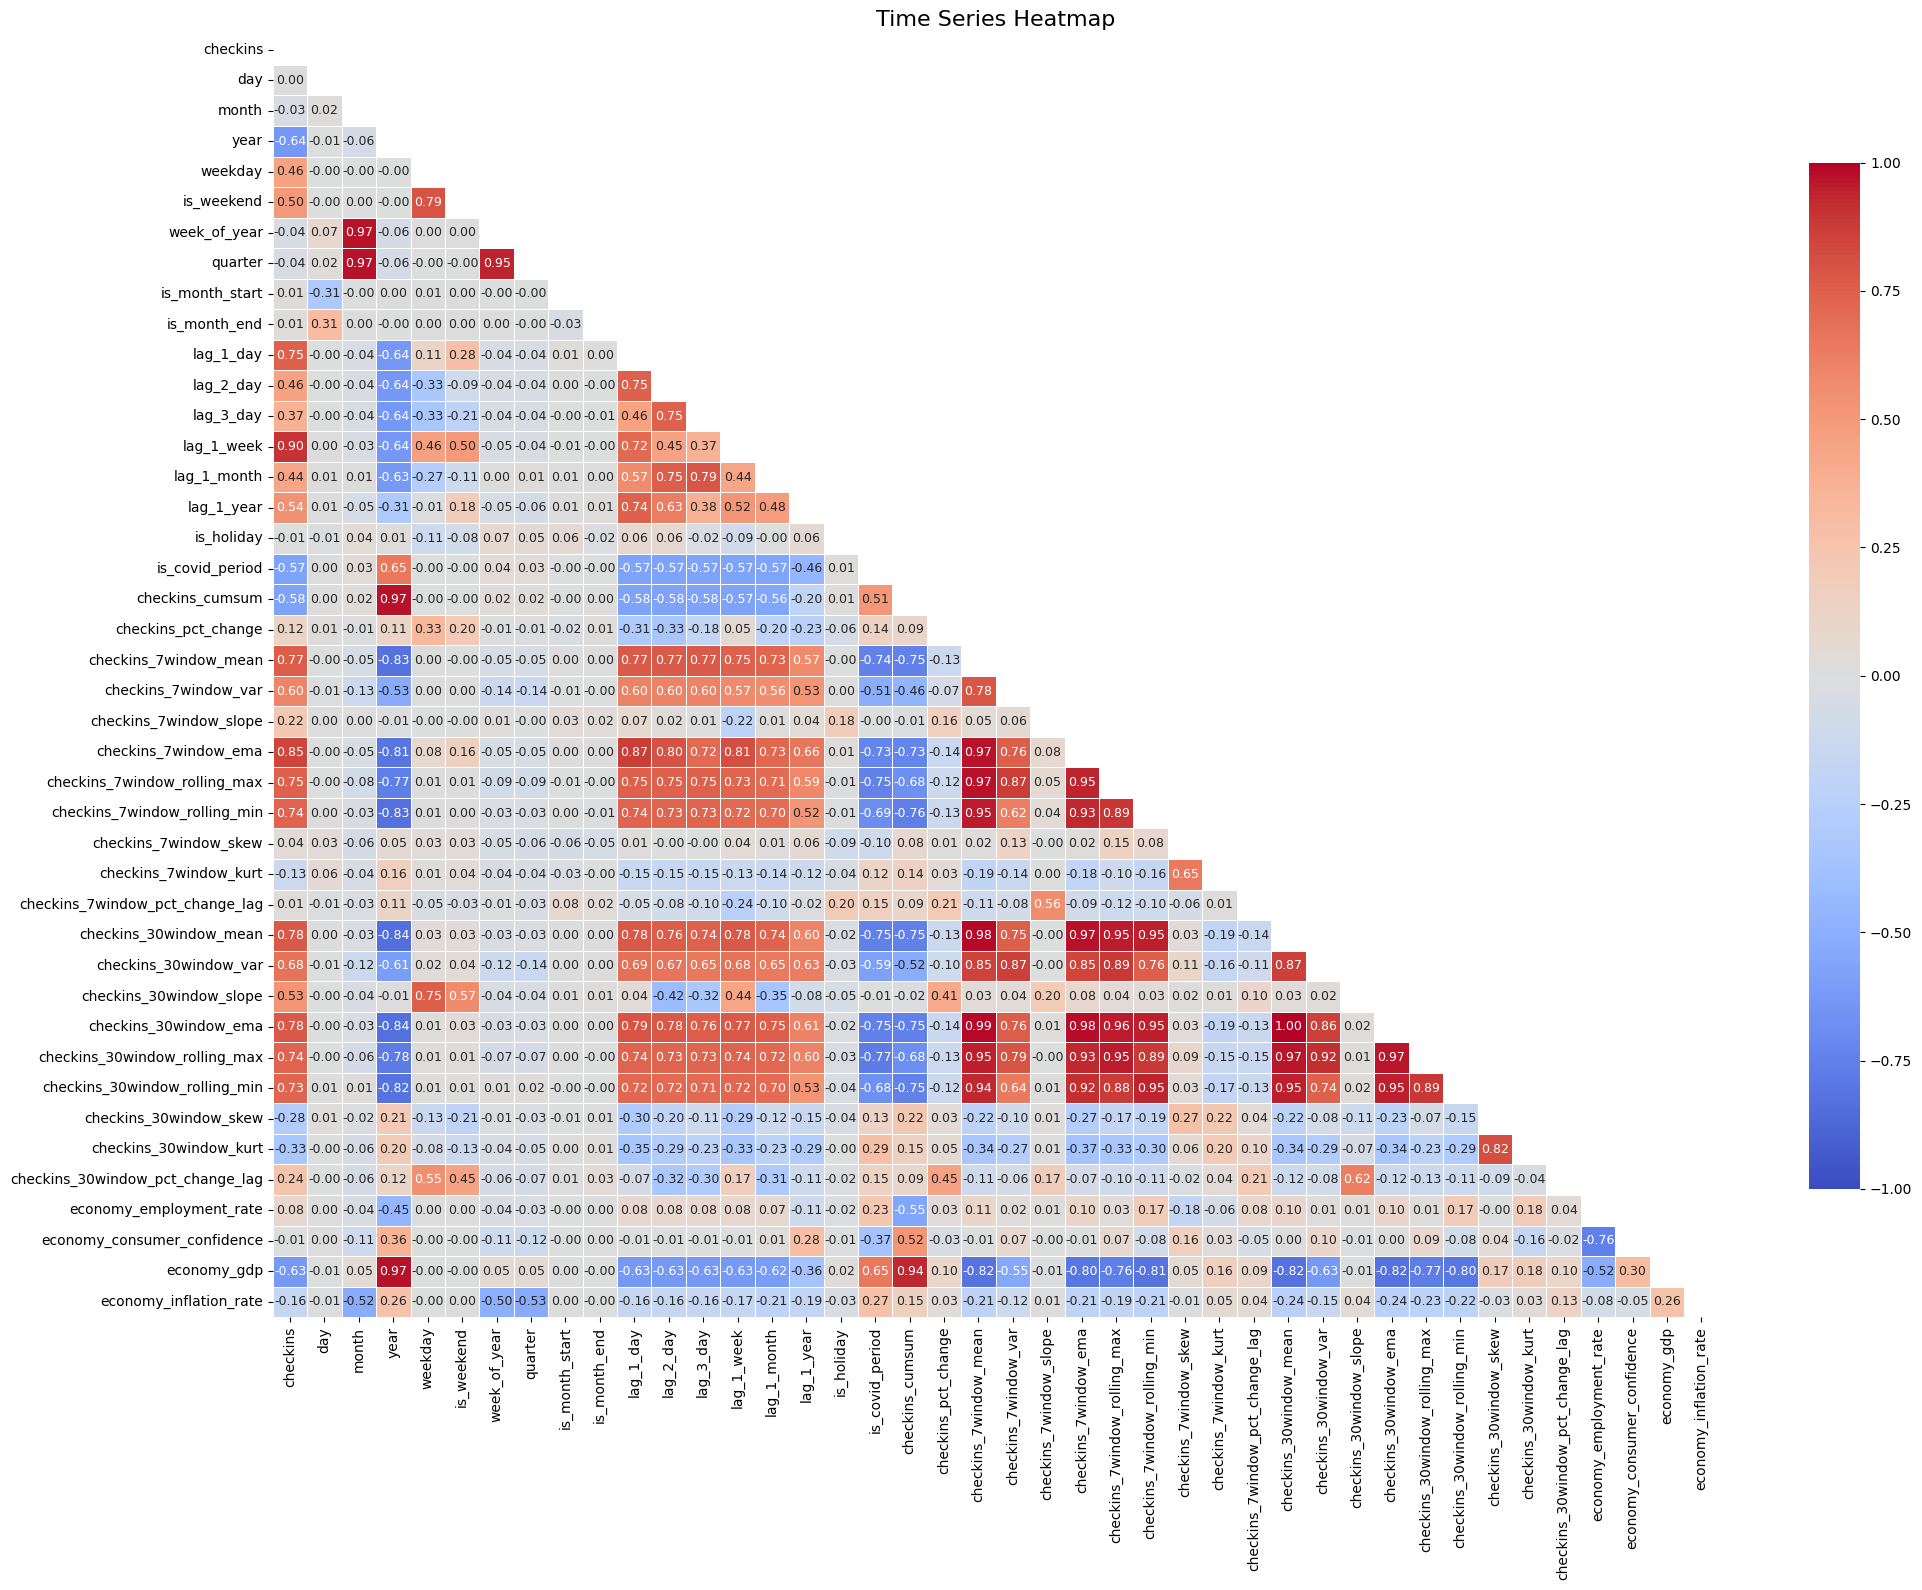

In [65]:
plot_timeseries_heatmap(final_df)

In [66]:
def get_high_correlation_columns(df: pd.DataFrame, target_col: str, threshold: float = 0.5):
    """
    Get columns with correlation greater than or equal to a positive threshold
    or less than or equal to a negative threshold with respect to the target column.
    
    df: Pandas DataFrame containing the data.
    target_col: The target column to calculate correlation against.
    threshold: Threshold for absolute correlation (default: 0.5).
    
    Returns:
    - A dictionary with column names and their correlation values.
    """
    # Calculate correlations with the target column
    correlations = df.corr()[target_col]
    
    # Filter columns based on correlation threshold
    high_corr_columns = correlations[
        (correlations >= threshold) | (correlations <= -threshold)
    ].sort_values(ascending=False)
    
    # Remove the target column from the result
    high_corr_columns = high_corr_columns.drop(target_col, errors='ignore')
    
    return high_corr_columns.index.to_list() + [target_col]

predictor_cols = get_high_correlation_columns(final_df, target_col="checkins", threshold=0.5)
predictor_cols

['lag_1_week',
 'checkins_7window_ema',
 'checkins_30window_mean',
 'checkins_30window_ema',
 'checkins_7window_mean',
 'checkins_7window_rolling_max',
 'lag_1_day',
 'checkins_30window_rolling_max',
 'checkins_7window_rolling_min',
 'checkins_30window_rolling_min',
 'checkins_30window_var',
 'checkins_7window_var',
 'lag_1_year',
 'checkins_30window_slope',
 'is_covid_period',
 'checkins_cumsum',
 'economy_gdp',
 'year',
 'checkins']

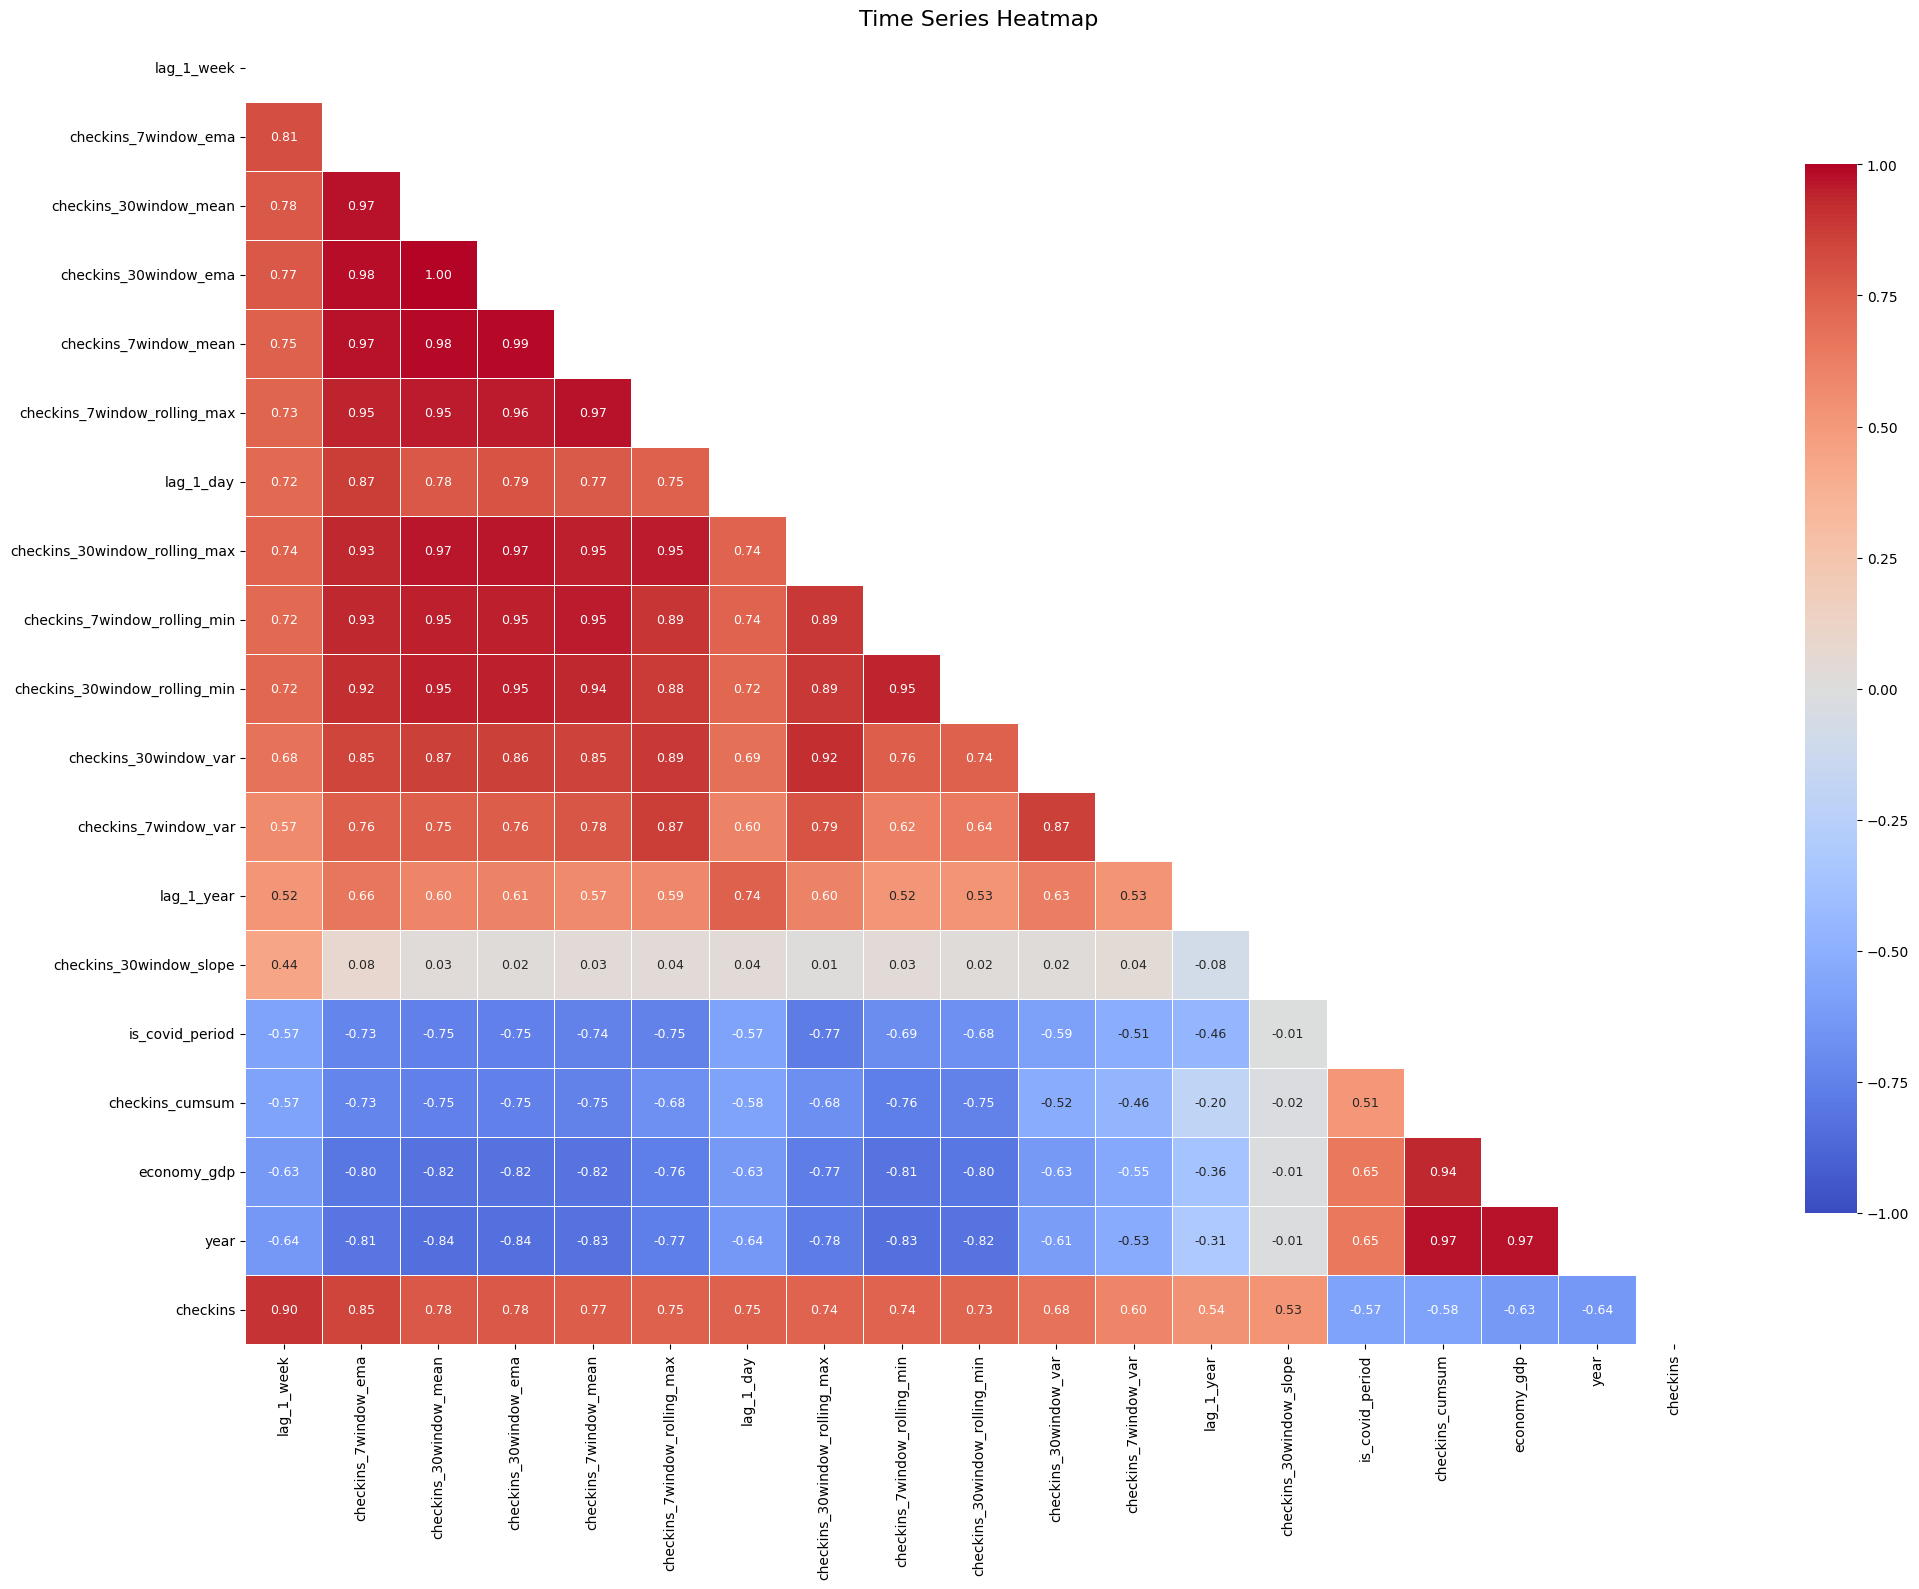

In [67]:
plot_timeseries_heatmap(final_df[predictor_cols])

In [68]:
import pandas as pd
import numpy as np

def filter_high_pairwise_correlation(df: pd.DataFrame, target_col: str, pairwise_threshold: float = 0.65):
    """
    Filter columns starting with 'checkins_' or 'lag_' by pairwise correlation, keeping only those
    with pairwise correlation below the given threshold.

    df: Pandas DataFrame containing the data.
    pairwise_threshold: Maximum allowed pairwise correlation among selected features (default: 0.75).

    Returns:
    - A list of selected column names with pairwise correlation <= pairwise_threshold.
    """
    # Filter columns that start with 'checkins_' or 'lag_'
    relevant_columns = [col for col in df.columns if col.startswith('checkins_') or col.startswith('lag_')]
    also_relevant = df.columns.difference(relevant_columns).to_list()
    also_relevant.remove(target_col)
    
    # Calculate the correlation matrix for the filtered columns
    corr_matrix = df[relevant_columns].corr()
    
    # Initialize a list for selected columns
    selected_columns = []
    
    for col in relevant_columns:
        # Check if this column has pairwise correlation <= pairwise_threshold with all already selected columns
        is_valid = True
        for selected_col in selected_columns:
            if abs(corr_matrix[col][selected_col]) > pairwise_threshold:
                is_valid = False
                break
        if is_valid:
            selected_columns.append(col)
    
    selected_columns.extend(also_relevant)
    return selected_columns

# Example usage:
final_predictors = filter_high_pairwise_correlation(final_df[predictor_cols], target_col="checkins", pairwise_threshold=0.75)
final_predictors

['lag_1_week',
 'checkins_7window_mean',
 'lag_1_year',
 'checkins_30window_slope',
 'checkins_cumsum',
 'economy_gdp',
 'is_covid_period',
 'year']

In [69]:
final_df = final_df[final_predictors + ["checkins"]]
final_df

lag_1_week  checkins_7window_mean  lag_1_year  \
2011-04-01        66.0              64.142857         3.0   
2011-04-02       107.0              62.714286         5.0   
2011-04-03        93.0              65.714286         9.0   
2011-04-04        35.0              66.142857         9.0   
2011-04-05        40.0              67.000000         9.0   
...                ...                    ...         ...   
2022-01-15        25.0              10.714286         5.0   
2022-01-16        22.0              10.285714         7.0   
2022-01-17         3.0              11.714286        13.0   
2022-01-18         2.0              12.142857         5.0   
2022-01-19        13.0              10.857143         6.0   

            checkins_30window_slope  checkins_cumsum  economy_gdp  \
2011-04-01                 1.333333           3936.0    15557.539   
2011-04-02                 2.166667           4033.0    15557.539   
2011-04-03                 2.233333           4147.0    15557.539   
2011-04-04                -1.700000           4185.0    15557.539   
2011-04-05                -0.733333           4231.0    15557.539   
...                             ...              ...          ...   
2022-01-15                 0.566667         252808.0    25215.491   
2022-01-16                 0.300000         252827.0    25215.491   
2022-01-17                -0.200000         252840.0    25215.491   
2022-01-18                -0.366667         252845.0    25215.491   
2022-01-19                -0.166667         252849.0    25215.491   

            is_covid_period  year  checkins  
2011-04-01                0  2011      76.0  
2011-04-02                0  2011      97.0  
2011-04-03                0  2011     114.0  
2011-04-04                0  2011      38.0  
2011-04-05                0  2011      46.0  
...                     ...   ...       ...  
2022-01-15                1  2022      19.0  
2022-01-16                1  2022      19.0  
2022-01-17                1  2022      13.0  
2022-01-18                1  2022       5.0  
2022-01-19                1  2022       4.0  

[3947 rows x 9 columns]

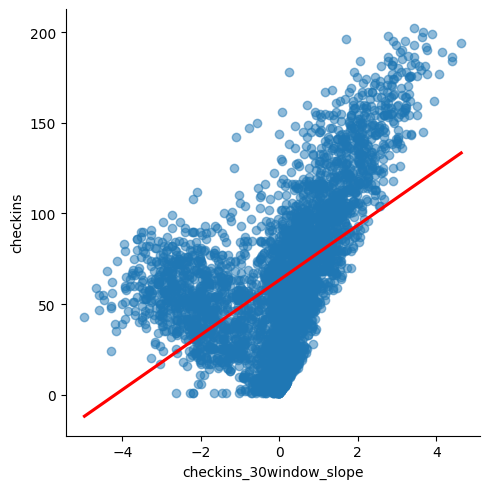

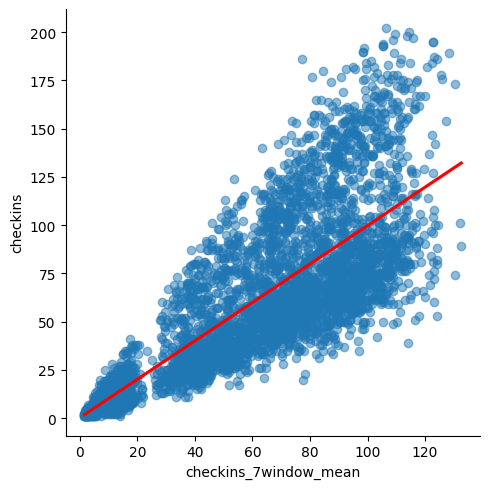

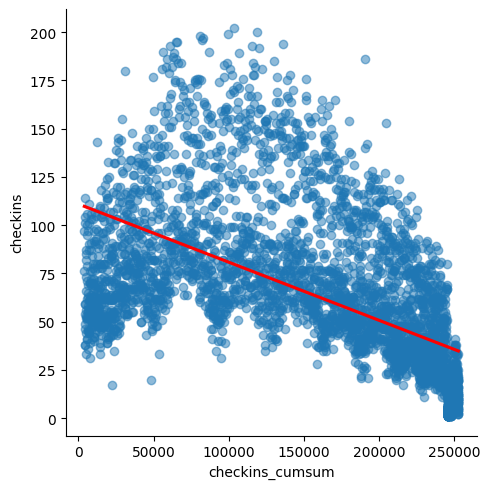

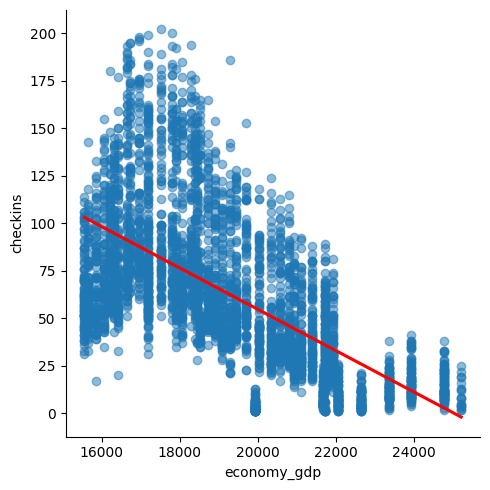

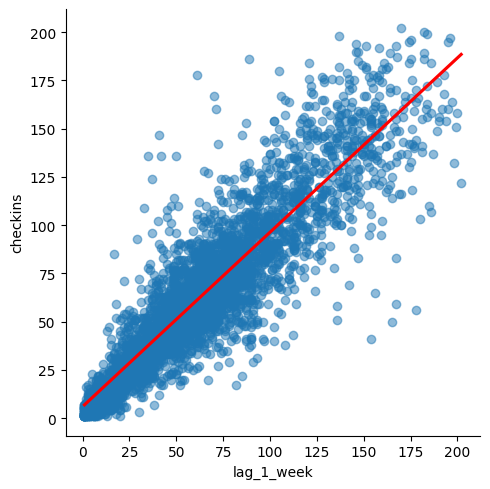

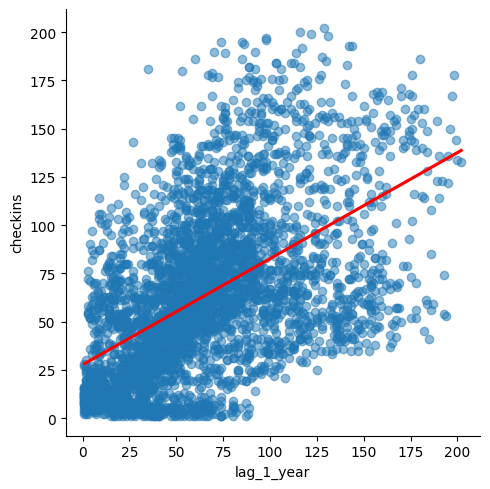

In [70]:
for col in final_df.columns.difference(["checkins", "year", "is_covid_period"]):
    sns.lmplot(x=col, y='checkins', data=final_df, 
            line_kws={'color': 'red'},
            ci=0.95,
            scatter_kws={'alpha': 0.5}, 
            lowess=False)

    # Display the plot
    plt.show()

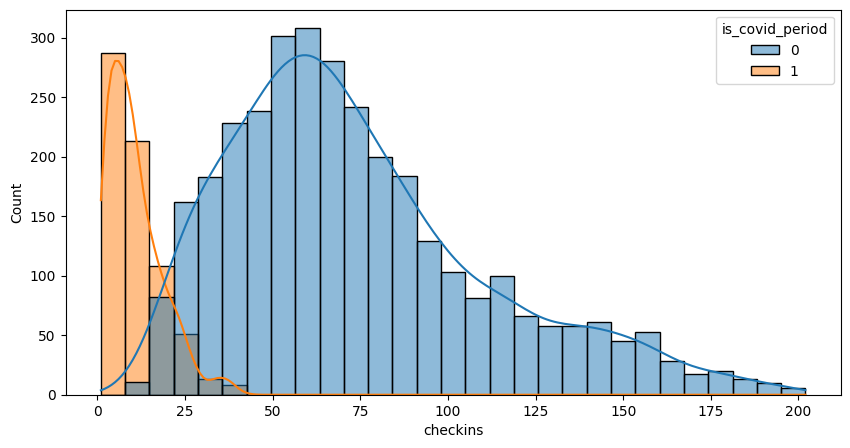

In [71]:
plt.figure(figsize=(10, 5))
sns.histplot(data=final_df, x="checkins", hue="is_covid_period", kde=True)
#plt.xticks(rotation=90)
plt.show()